# Notebook for training

In [ ]:
# Standard library
import os
import sys

# Third-party libraries
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

# Local imports
from scripts.dynamicTW import *

In [77]:
# data
file_path = "../data/laser.mat"
mat = loadmat(file_path)

X = mat["X"]
y = mat["Y"].reshape(200)

print(X.shape, y.shape)

(200, 60) (200,)


In [78]:
# configs

seed = 42  # for repeatability

In [79]:
y_binary = (y == 1).astype(int)

# normalizing the data
X = (X - X.mean(axis=1, keepdims=True)) / X.std(axis=1, keepdims=True)
X_train, X_test, y_train, y_test = train_test_split(
    X, y_binary, test_size=0.2, random_state=seed
)

## Linear Classification (baseline)



              precision    recall  f1-score   support

           0       0.80      0.94      0.86        17
           1       0.95      0.83      0.88        23

    accuracy                           0.88        40
   macro avg       0.88      0.88      0.87        40
weighted avg       0.89      0.88      0.88        40

[-6.90055177e+11 -6.90055177e+11 -6.90055177e+11 -6.90055177e+11
 -6.90055177e+11 -6.90055177e+11 -6.90055177e+11 -6.90055177e+11
 -6.90055177e+11 -6.90055177e+11 -6.90055177e+11 -6.90055177e+11
 -6.90055177e+11 -6.90055177e+11 -6.90055177e+11 -6.90055177e+11
 -6.90055177e+11 -6.90055177e+11 -6.90055177e+11 -6.90055177e+11
 -6.90055177e+11 -6.90055177e+11 -6.90055177e+11 -6.90055177e+11
 -6.90055177e+11 -6.90055177e+11 -6.90055177e+11 -6.90055177e+11
 -6.90055177e+11 -6.90055177e+11 -6.90055177e+11 -6.90055177e+11
 -6.90055177e+11 -6.90055177e+11 -6.90055177e+11 -6.90055177e+11
 -6.90055177e+11 -6.90055177e+11 -6.90055177e+11 -6.90055177e+11
 -6.90055177e+11 -6.900

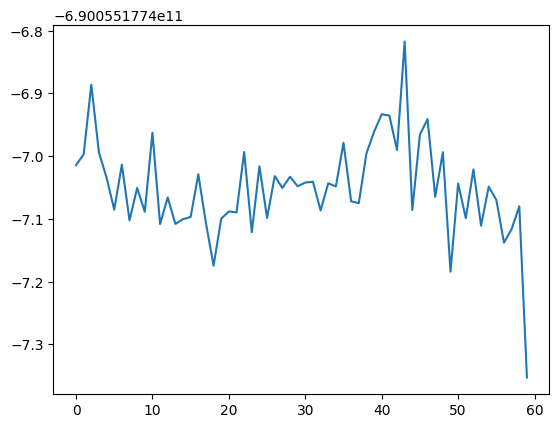

In [80]:
clf_base = LinearRegression()
clf_base.fit(X_train, y_train)
y_pred = clf_base.predict(X_test)
y_pred_class = (y_pred >= 0.5).astype(int)
print(classification_report(y_test, y_pred_class))
print(clf_base.coef_)
plt.plot(clf_base.coef_)

## 1. Logistic regression 

In [81]:
clf_log = LogisticRegression(max_iter=1000)
clf_log.fit(X_train, y_train)
y_pred_log = clf_log.predict(X_test)
print(classification_report(y_test, y_pred_log))
print(clf_log.coef_)

              precision    recall  f1-score   support

           0       0.83      0.88      0.86        17
           1       0.91      0.87      0.89        23

    accuracy                           0.88        40
   macro avg       0.87      0.88      0.87        40
weighted avg       0.88      0.88      0.88        40

[[ 0.73254237  0.51839282  0.97927241  0.23279069  0.26690511 -0.04936297
   0.40761628 -0.54296384  0.19691988 -0.39000791  0.35413935 -0.49546519
  -0.08138414 -0.47343106 -0.17951089 -0.70806609 -0.19136007 -0.25061654
  -0.68224421 -0.78425273 -0.55343356 -0.62303318  0.53698434 -0.06578599
   0.05919269 -0.22537544  0.18617298 -0.5750014   0.43597459  0.09549242
   0.13819411 -0.17712518  0.23029482 -0.25035217  0.34974363  0.39596334
   0.12143829 -0.03329684  0.39382753  0.5593588   1.02272752  1.02572961
   0.60943448  1.45096761 -0.17045668  0.59053171  0.66754454 -0.06875568
   0.55975275 -0.94852448  0.0050136  -0.21818438  0.12076902 -0.55769448
   0.06

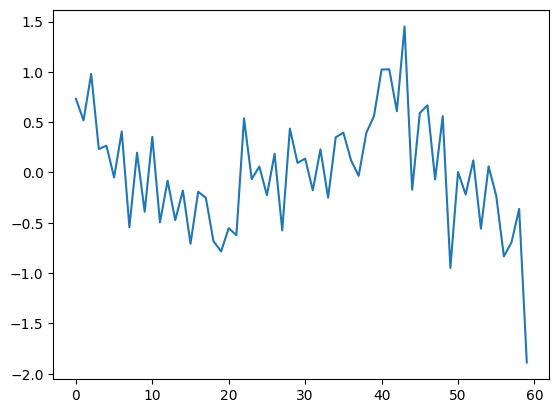

In [82]:
plt.plot(clf_log.coef_[0])

## 2. Kernal SVM using Dynamic Time Warping

In [ ]:
clf_dtw = KernelEstimator(k2_hyp(1), 10)
clf_dtw.fit(X_train, y_train)
y_preds_dtw = clf_dtw.predict(X_test)

In [84]:
y_preds_dtw = (y_preds_dtw == 1).astype(int)
print(y_preds_dtw)

[1 1 1 1 1 1 0 1 1 1 1 1 0 0 1 1 1 1 0 1 1 0 1 1 0 0 0 1 1 1 1 1 0 1 1 1 0
 1 1 0]


In [85]:
print(classification_report(y_test, y_preds_dtw))

              precision    recall  f1-score   support

           0       0.73      0.47      0.57        17
           1       0.69      0.87      0.77        23

    accuracy                           0.70        40
   macro avg       0.71      0.67      0.67        40
weighted avg       0.71      0.70      0.69        40



In [ ]:
from sklearn.model_selection import KFold, GridSearchCV, RandomizedSearchCV
from sklearn.base import clone
import numpy as np


def nested_cv(
    estimator,
    X,
    y,
    param_grid,
    inner_cv=5,
    outer_cv=5,
    scoring="accuracy",
    search_type="grid",
    n_iter=50,
    random_state=None,
    return_models=False,
):
    """
    Perform nested cross-validation for sklearn-style models.

    Parameters
    ----------
    estimator : sklearn estimator
        Any estimator following the scikit-learn API.

    X : array-like
        Feature matrix.

    y : array-like
        Target vector.

    param_grid : dict
        Dictionary of hyperparameters to tune.

    inner_cv : int
        Number of folds for inner cross-validation (hyperparameter tuning).

    outer_cv : int
        Number of folds for outer cross-validation (performance estimation).

    scoring : str or callable
        Scoring metric to use.

    search_type : {'grid', 'random'}
        Whether to use GridSearchCV or RandomizedSearchCV.

    n_iter : int
        Number of iterations for RandomizedSearchCV (ignored if search_type='grid').

    random_state : int, optional
        Random seed for reproducibility.

    return_models : bool
        If True, return the trained best estimators from each outer fold.

    Returns
    -------
    results : dict
        Dictionary containing:
            'outer_scores': list of scores for each outer fold
            'mean_score': mean of outer scores
            'std_score': standard deviation of outer scores
            'best_params': list of best hyperparameters from each fold
            'models': list of trained models (if return_models=True)
    """

    outer_cv_splitter = KFold(
        n_splits=outer_cv, shuffle=True, random_state=random_state
    )
    outer_scores = []
    best_params = []
    models = []

    for train_idx, test_idx in outer_cv_splitter.split(X, y):
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]

        # Inner CV for hyperparameter tuning
        if search_type == "grid":
            search = GridSearchCV(
                estimator=clone(estimator),
                param_grid=param_grid,
                cv=inner_cv,
                scoring=scoring,
                n_jobs=-1,
            )
        elif search_type == "random":
            search = RandomizedSearchCV(
                estimator=clone(estimator),
                param_distributions=param_grid,
                n_iter=n_iter,
                cv=inner_cv,
                scoring=scoring,
                random_state=random_state,
                n_jobs=-1,
            )
        else:
            raise ValueError("search_type must be 'grid' or 'random'")

        search.fit(X_train, y_train)
        best_estimator = search.best_estimator_
        best_params.append(search.best_params_)

        # Evaluate on outer fold test set
        score = search.score(X_test, y_test)
        outer_scores.append(score)

        if return_models:
            models.append(best_estimator)

    results = {
        "outer_scores": outer_scores,
        "mean_score": np.mean(outer_scores),
        "std_score": np.std(outer_scores),
        "best_params": best_params,
    }
    if return_models:
        results["models"] = models

    return results